In [1]:
num_weeks = 42

## VENTAS

In [2]:
import xmlrpc.client
from datetime import date, timedelta, datetime
import pandas as pd

# Conexión con Odoo (manteniendo tus credenciales)
username = "juan.cano@donsson.com"  # tu usuario
password = "1000285668"         # tu contraseña
url = "https://donsson.com"     # URL del servidor
db = "Donsson_produccion" # nombre de la base de datos


# --- Autenticación ---
common = xmlrpc.client.ServerProxy(f"{url}/xmlrpc/2/common")
uid = common.authenticate(db, username, password, {})
models = xmlrpc.client.ServerProxy(f"{url}/xmlrpc/2/object")

# --- Fechas ---
weeks = num_weeks

# --- Fechas automáticas ---
hoy = date.today()
fecha_fin = hoy.strftime("%Y-%m-%d")
fecha_inicio = (hoy - timedelta(weeks=weeks)).strftime("%Y-%m-%d")

# --- 1) Buscar facturas válidas (account.invoice) ---

invoice_domain = [
    ("date_invoice", ">=", fecha_inicio),
    ("date_invoice", "<=", fecha_fin),
    ("type", "=", "out_invoice"),    # solo ventas
    ("state", "in", ["open", "paid"])
]

invoice_ids = models.execute_kw(
    db, uid, password,
    "account.invoice", "search",
    [invoice_domain]
)
print(f"Facturas encontradas: {len(invoice_ids)}")

# --- 2) Descargar las líneas de esas facturas (account.invoice.line) ---

# Campos de la LÍNEA de factura. Eliminamos 'number', 'user_id', 'section_id', 'partner_id' porque irán en la factura.
line_fields = ["product_id", "quantity", "price_subtotal", "invoice_id","create_date","origin"] 

records = []
limit = 20000
offset = 0

while True:
    result = models.execute_kw(
        db, uid, password,
        "account.invoice.line", "search_read",
        [[("invoice_id", "in", invoice_ids)]],
        {"fields": line_fields, "limit": limit, "offset": offset}
    )
    if not result:
        break
    records.extend(result)
    offset += limit
    print(f"Descargados {len(records)} registros de líneas...")

# --- 3) Pasar a DataFrame de líneas ---
line_df = pd.DataFrame(records).fillna(0)


# Separar product_id
line_df["product_id_num"] = line_df["product_id"].apply(
    lambda x: x[0] if isinstance(x, (list, tuple)) else None
)
line_df["product_name"] = line_df["product_id"].apply(
    lambda x: x[1] if isinstance(x, (list, tuple)) else str(x)
)

# Separar invoice_id
line_df["invoice_id_num"] = line_df["invoice_id"].apply(
    lambda x: x[0] if isinstance(x, (list, tuple)) else None
)
line_df["invoice_name"] = line_df["invoice_id"].apply(
    lambda x: x[1] if isinstance(x, (list, tuple)) else str(x)
)

# Convertir fecha a datetime
line_df["date_invoice"] = pd.to_datetime(line_df["create_date"], errors="coerce")

# Eliminar las columnas originales problemáticas
line_df = line_df.drop(columns=["product_id", "invoice_id","create_date"])

print(f"Total de líneas descargadas: {len(line_df)}")

# ----------------------------------------------------
# --- 4) Descargar los campos adicionales de Factura (account.invoice) ---
# ----------------------------------------------------
# Añadimos los campos que quieres: number, user_id, section_id, y también partner_id y store_id
invoice_fields = ["id", "store_id", "number", "user_id", "section_id", "partner_id"]
invoices = models.execute_kw(
    db, uid, password,
    "account.invoice", "read",
    [invoice_ids], # Solo las facturas que encontramos
    {"fields": invoice_fields}
)
invoice_df = pd.DataFrame(invoices)

# --- 5) Procesar campos de la factura ---

# Separar store_id
invoice_df["store_name"] = invoice_df["store_id"].apply(
    lambda x: x[1] if isinstance(x, (list, tuple)) else str(x)
)

# Separar user_id (Vendedor)
invoice_df["salesperson_name"] = invoice_df["user_id"].apply(
    lambda x: x[1] if isinstance(x, (list, tuple)) else None
)

# Separar section_id (Equipo de Ventas)
invoice_df["sales_team_name"] = invoice_df["section_id"].apply(
    lambda x: x[1] if isinstance(x, (list, tuple)) else None
)

# Separar partner_id (Cliente/Partner)
invoice_df["partner_id_num"] = invoice_df["partner_id"].apply(
    lambda x: x[0] if isinstance(x, (list, tuple)) else None
)
# El nombre del partner es el segundo elemento de la tupla (si existe)
invoice_df["client_name_inv"] = invoice_df["partner_id"].apply(
    lambda x: x[1] if isinstance(x, (list, tuple)) else None
)


# Eliminar columnas originales no deseadas o ya procesadas
invoice_df = invoice_df.drop(columns=["store_id", "user_id", "section_id", "partner_id"])


# ----------------------------------------------------
# --- 6) Fusionar DataFrames ---
# ----------------------------------------------------

# Fusionamos las líneas de factura (line_df) con los datos de las facturas (invoice_df)
df = line_df.merge(
    invoice_df, 
    left_on="invoice_id_num", 
    right_on="id", 
    how="left"
)

# Limpieza final de columnas de IDs de factura
df = df.drop(columns=["invoice_id_num", "product_id_num"])


df['origin'] = df['origin'].astype('string')

# 2 minutos 15 semanas

Facturas encontradas: 42827
Descargados 20000 registros de líneas...
Descargados 40000 registros de líneas...
Descargados 60000 registros de líneas...
Descargados 80000 registros de líneas...
Descargados 100000 registros de líneas...
Descargados 120000 registros de líneas...
Descargados 140000 registros de líneas...
Descargados 160000 registros de líneas...
Descargados 167033 registros de líneas...
Total de líneas descargadas: 167033


In [3]:
df["quantity"].describe()

count    167033.000000
mean          3.413337
std          15.874415
min           1.000000
25%           1.000000
50%           1.000000
75%           3.000000
max        2794.000000
Name: quantity, dtype: float64

## VENTAS PERDIDAS

In [4]:
import xmlrpc.client
from datetime import date, timedelta
import pandas as pd

# ===============================
# 1. Conexión con Odoo
# ===============================

ODOO_URL = "https://donsson.com"
ODOO_DB = "Donsson_produccion"
ODOO_USERNAME = "juan.cano@donsson.com"
ODOO_PASSWORD = "1000285668"

# Autenticación
common = xmlrpc.client.ServerProxy(f"{ODOO_URL}/xmlrpc/2/common")
uid = common.authenticate(ODOO_DB, ODOO_USERNAME, ODOO_PASSWORD, {})
if not uid:
    print("Error de autenticación. Verifica tus credenciales.")
    exit()
models = xmlrpc.client.ServerProxy(f"{ODOO_URL}/xmlrpc/2/object")

# ===============================
# 2. Definir rango de semanas
# ===============================

# Número de semanas que quieres descargar (puedes cambiarlo)
NUM_SEMANAS = num_weeks

# Fecha de hoy
hoy = date.today()
# Fecha de inicio según número de semanas atrás
fecha_inicio = hoy - timedelta(weeks=NUM_SEMANAS)

FECHA_INICIO = fecha_inicio.strftime("%Y-%m-%d")
FECHA_FIN = hoy.strftime("%Y-%m-%d")

print(f"📅 Descargando registros desde {FECHA_INICIO} hasta {FECHA_FIN}")

# ===============================
# 3. Leer ventas perdidas
# ===============================

lost_sales_ids = models.execute_kw(
    ODOO_DB, uid, ODOO_PASSWORD,
    "ventas.perdidas", "search",
    [[["fecha", ">=", FECHA_INICIO], ["fecha", "<=", FECHA_FIN], ["almacenamiento_tipo", "=", "agotado"]]]
)

lost_sales_data = models.execute_kw(
    ODOO_DB, uid, ODOO_PASSWORD,
    "ventas.perdidas", "read",
    [lost_sales_ids],
    {"fields": ["origen", "store_id", "cliente_id", "fecha", "product_ref",
                "cantidad", "cantidad_existencia", "cantidad_reservada",
                "almacenamiento_tipo"]}
)

df_vp = pd.DataFrame(lost_sales_data)

# ===============================
# 4. Normalizar columnas
# ===============================

for col in ["store_id", "cliente_id"]:
    df_vp[col.replace('_id', '_name')] = df_vp[col].apply(
        lambda x: x[1] if isinstance(x, (list, tuple)) and len(x) > 1 else str(x) if x else None
    )
    df_vp[col + "_num"] = df_vp[col].apply(
        lambda x: x[0] if isinstance(x, (list, tuple)) and len(x) > 0 else None
    )

# Eliminar columnas originales
df_vp = df_vp.drop(columns=["id", "store_id", "cliente_id"], errors='ignore')

# ===============================
# 4.1. Forzar tipos de columnas antes de exportar
# ===============================
for col in df_vp.columns:
    if col.endswith("_num"):
        df_vp[col] = pd.to_numeric(df_vp[col], errors="coerce").astype("Int64")
    else:
        df_vp[col] = df_vp[col].astype("string")

df_vp = df_vp.copy()


📅 Descargando registros desde 2025-02-03 hasta 2025-11-24


In [5]:
df_vp[df_vp["product_ref"]=="DAB14666025"]

,cantidad_reservada,product_ref,cantidad,almacenamiento_tipo,fecha,cantidad_existencia,origen,store_name,store_id_num,cliente_name,cliente_id_num
1412,0,DAB14666025,1,agotado,2025-02-07,0,cotizacion,SUCURSAL BUCARAMANGA,11,[CO9004542063] MAVIAL S.A.S.,34327
2955,0,DAB14666025,1,agotado,2025-02-14,0,cotizacion,SUCURSAL NORTE,7,[CC222222222228] CONSUMIDOR FINAL NORTE,27642
3084,0,DAB14666025,1,agotado,2025-02-14,0,cotizacion,SUCURSAL CALI,15,[CC1114391605] OSCAR ANDRES LOPEZ HERRERA,38564
3750,1,DAB14666025,1,agotado,2025-02-18,0,cotizacion,SUCURSAL CALLE 6,2,[CC222222222221] CONSUMIDOR FINAL CALLE 6,27635
4640,0,DAB14666025,1,agotado,2025-02-20,0,cotizacion,SUCURSAL VALLADOLID,6,[CC222222222223] CONSUMIDOR FINAL VALLADOLID,27638
6753,0,DAB14666025,1,agotado,2025-03-01,0,cotizacion,SUCURSAL NORTE,7,[CC222222222228] CONSUMIDOR FINAL NORTE,27642
7336,0,DAB14666025,1,agotado,2025-03-04,0,cotizacion,SUCURSAL NORTE,7,[CO8600030638] COMPAÑIA DE TRABAJOS URBANOS S.A.S,2933
11981,0,DAB14666025,1,agotado,2025-03-25,0,cotizacion,SUCURSAL BARRANQUILLA,10,[CO9003328012] EQUISANDER S.A.S,29042
12523,0,DAB14666025,1,agotado,2025-03-27,0,cotizacion,SUCURSAL MEDELLIN,8,[CO9016420343] MANGUERAS Y TORNILLOS LAS ARCIL...,35001
13142,0,DAB14666025,2,agotado,2025-03-29,1,cotizacion,SUCURSAL CALLE 6,2,[CO9017262287] HIDRAULICOS ARAUCA S.A.S. ZOMAC,36953


In [6]:
df_vp.sample(10)

,cantidad_reservada,product_ref,cantidad,almacenamiento_tipo,fecha,cantidad_existencia,origen,store_name,store_id_num,cliente_name,cliente_id_num
20878,0,DAE09048025,1,agotado,2025-05-12,0,cotizacion,PRINCIPAL COTA,1,[CC80259465] BARON ALBARRACIN JHON FREDY,3335
48320,0,BCS20364125,1,agotado,2025-10-01,0,cotizacion,PRINCIPAL COTA,1,[CO191461130] MARIO ALBERTO HUERTAS COTES,14473
43837,2,BHS00224125,1,agotado,2025-09-10,0,cotizacion,SUCURSAL BARRANQUILLA,10,[CC222222222225] CONSUMIDOR FINAL BARRANQUILLA,27636
3321,0,BCS10472125,6,agotado,2025-02-17,5,cotizacion,SUCURSAL VALLADOLID,6,[CC222222222223] CONSUMIDOR FINAL VALLADOLID,27638
53107,0,BAE02427125,1,agotado,2025-10-28,0,cotizacion,SUCURSAL BUCARAMANGA,11,[CC743597301] LEONARDO AMEZQUITA,10530
26023,0,BAR08056125,1,agotado,2025-06-09,0,cotizacion,PRINCIPAL COTA,1,[CC80278085] ABEL MAURICIO ORJUELA LINARES,4515
9776,0,BHE00951125,2,agotado,2025-03-13,0,cotizacion,SUCURSAL VALLADOLID,6,[CC222222222223] CONSUMIDOR FINAL VALLADOLID,27638
29647,0,BHS00391125,1,agotado,2025-07-01,0,pos,SUCURSAL BARRANQUILLA,10,[CO9002263032] SERVICIOS Y LUBRICANTES TRANSPO...,3065
37251,0,BLE00094125,1,agotado,2025-08-12,0,cotizacion,SUCURSAL BUCARAMANGA,11,[CC222222222227] CONSUMIDOR FINAL GIRON,27639
6991,0,DAR08097025,1,agotado,2025-03-03,0,cotizacion,PRINCIPAL COTA,1,[CO9001703996] IMPORTADORA CASA COLOMBIA SAS,7074


In [7]:
df_vp.to_excel("/home/donsson/proyectos/MODELO ABASTECIMIENTO/csvsalidas/vp_intermillenium.xlsx")

In [8]:
import pandas as pd
import numpy as np

# ===============================
# Filtrar almacenamiento agotado
# ===============================
df_vp = df_vp[df_vp["almacenamiento_tipo"].str.lower() == "agotado"]

# ===============================
# Asegurar tipos correctos
# ===============================
df_vp = df_vp.copy()
df_vp["fecha"] = pd.to_datetime(df_vp["fecha"], errors="coerce")

# Numéricos
for col in ["cantidad", "cantidad_existencia", "cantidad_reservada"]:
    df_vp[col] = pd.to_numeric(df_vp[col], errors="coerce").fillna(0).clip(lower=0)

# ===============================
# Reglas Odoo vectorizadas
# ===============================
is_cot = df_vp["origen"].fillna("").str.lower() == "cotizacion"
ignore_mask = df_vp["cantidad"] >= 100 #percentiles evaluar

ajuste = np.where(
    is_cot,
    df_vp["cantidad"] - df_vp["cantidad_existencia"] - df_vp["cantidad_reservada"],
    df_vp["cantidad"] - df_vp["cantidad_reservada"]
)

# Aplicar reglas de descarte y piso en cero
ajuste = np.where(ignore_mask, 0, ajuste)
ajuste = np.where(ajuste > 0, ajuste, 0)

df_vp["ventas_perdidas"] = ajuste.astype(float)

# ===============================
# Columnas temporales
# ===============================
df_vp["Semana"] = df_vp["fecha"].dt.to_period("W").dt.start_time
df_vp["ano"]   = df_vp["Semana"].dt.year
df_vp["mes"]   = df_vp["Semana"].dt.month
df_vp["dia"]   = df_vp["Semana"].dt.day

# ===============================
# Filtro adicional: excluir SERV y CARCASA
# ===============================
mask_excluir = ~df_vp["product_ref"].str.contains("SERV|CARCASA", case=False, na=False)
df_vp = df_vp[mask_excluir]


df_vp.to_excel("/home/donsson/proyectos/MODELO ABASTECIMIENTO/exceles/vp_meses/vp_def.xlsx")
# ===============================
# Agrupación por tienda + producto + semana
# ===============================
lost_by_week = (
    df_vp.groupby(["store_name", "product_ref", "Semana", "ano", "mes", "dia"])
    .agg(
        lost_sales=("ventas_perdidas", "sum"),   # suma total de ventas perdidas
        veces_vp=("ventas_perdidas", "count")    # número de veces que hubo pérdida
    )
    .reset_index()
)

# Mostrar resultado agrupado
vp_week = lost_by_week

In [9]:
vp_week.head()

,store_name,product_ref,Semana,ano,mes,dia,lost_sales,veces_vp
0,PRINCIPAL COTA,3LTKB400,2025-10-20,2025,10,20,15.0,1
1,PRINCIPAL COTA,AC10388020,2025-09-22,2025,9,22,36.0,4
2,PRINCIPAL COTA,AGB0GRAS030,2025-07-28,2025,7,28,1.0,1
3,PRINCIPAL COTA,AHB80W90030,2025-07-07,2025,7,7,1.0,1
4,PRINCIPAL COTA,AHB80W90050,2025-08-11,2025,8,11,1.0,1


## COSTOS

In [10]:
import xmlrpc.client
import pandas as pd


# ===============================
# Conexión con Odoo
# ===============================
username = "juan.cano@donsson.com"   # tu usuario
password = "1000285668"              # tu contraseña
url = "https://donsson.com"          # URL del servidor
db = "Donsson_produccion"            # nombre de la base de datos

common = xmlrpc.client.ServerProxy(f"{url}/xmlrpc/2/common")
uid = common.authenticate(db, username, password, {})
models = xmlrpc.client.ServerProxy(f"{url}/xmlrpc/2/object")


#df_campos.info()


productos_costo = models.execute_kw(
    db , uid , password,
    "cs.analisis.costo","search_read",
    [[]],
    {"fields":["producto_costo_unitario","producto_id"]}


)

# Convertir en df
df_p = pd.DataFrame(productos_costo)


# Separar lista anidada
df_p[["product_id_num","product_name"]] = (df_p["producto_id"].apply(pd.Series))

#Agregar columna estandarizada
df_p["product_name"] = df_p["product_name"].str.strip()

#DF normalizado
df_p = df_p[["product_name","producto_costo_unitario"]]

In [11]:
df_p.to_excel("/home/donsson/proyectos/MODELO ABASTECIMIENTO/csvsalidas/costs.xlsx")

# EDA

## Facturas

In [12]:
import re
import unicodedata



mapa_sucursales = {
    'BD1': 'PRINCIPAL COTA',
    'BD2': 'SUCURSAL CALLE 6',
    'BD3': 'SUCURSAL VALLADOLID',
    'BD4': 'SUCURSAL NORTE',
    'BD5': 'SUCURSAL MEDELLIN',
    'BD6': 'SUCURSAL BARRANQUILLA',
    'BD7':' SUCURSAL BUCARAGAMNGA ',
    'BD8':'MOSTRADOR COTA',
    'BD9':'SUCURSAL CALI',
    'BD11': 'CUMMINS DE LOS ANDES',
    'BD12': 'CUMMINS DE LOS ANDES MEDELLIN',
    'BD13': 'CSS CONSTRUCTORES',
    'BD14': 'ANTIOQUEÑA DE LUBRICANTES SGP SAS',
    'BD15': 'ASEO CAPITAL',
    'BD16': 'COVIANDES',
    'BD18': 'CEMEX BOSA',
    'BD19': 'Cemex ibague (eliminar)',
    'BD21': 'CEMEX CENTENARIO',
    'BD22': 'PENDIENTE POR FACTURAR CIERRE CONT.',
    'BD24': 'FILTRO EN REPROCESO',
    'BD26': 'PRESTAMOS INTERNOS',
    'BD31': 'EXP.CTP',
    'BD32': 'EXP. ECUADOR',
    'BD34':'EXP.DONSSON.USA',
    'BD40': 'DESCUADRE B1',
    'BD MP':'MATERIA PRIMA',
    'BD41':'BODEGA VENDEDOR WILMER GIL',
    'BD33':'EXP.REP.DOMINICANA',
    'BD42':'STOCK SIGMA ENERGY'
    # Agrega más códigos si los encuentras en tus datos, siguiendo este formato.
    }




def clasificar_sucursal(invoice_name):
    if pd.isna(invoice_name):
        return "VENDEDOR EXTERNO"
    if "Mostrador" in invoice_name:
        return "MOSTRADOR"
    return "VENDEDOR EXTERNO"
    
df["Sucursal_tipo"] = df["invoice_name"].apply(clasificar_sucursal)




#Quitar las facturas que salen como SO son no vendibles
df = df[~(df["origin"].str.contains("SO"))] 


# Normalizar los separadores para que todos sean iguales
df["origin_norm"] = df["origin"].str.replace(r"[\\/]", "/", regex=True)

# Extraer solo el BD y el número (ejemplo: BD11, BD9, etc.)
df["origen"] = df["origin_norm"].str.extract(r"^(BD\d+)")

df["Bodega"] = df["origen"].map(mapa_sucursales)
df["Bodega"] = df["Bodega"].fillna(df["store_name"])

df = df.drop(columns=["origin_norm"])


df = df.drop(columns=["origin"])

df_externos_bogota = df[(df["store_name"]=="PRINCIPAL COTA") & (df["Sucursal_tipo"]=="VENDEDOR EXTERNO")]

df = df.drop(df_externos_bogota.index)


In [13]:
df.groupby(["store_name","Bodega","Sucursal_tipo"])["quantity"].sum()

store_name             Bodega                             Sucursal_tipo   
PRINCIPAL COTA         PRINCIPAL COTA                     MOSTRADOR           12685.0
SUCURSAL BARRANQUILLA  SUCURSAL BARRANQUILLA              MOSTRADOR           21260.0
                                                          VENDEDOR EXTERNO    57927.0
SUCURSAL BUCARAMANGA    SUCURSAL BUCARAGAMNGA             VENDEDOR EXTERNO    39459.0
                       PRINCIPAL COTA                     VENDEDOR EXTERNO        2.0
                       SUCURSAL BUCARAMANGA               MOSTRADOR           15664.0
SUCURSAL CALI          BODEGA VENDEDOR WILMER GIL         VENDEDOR EXTERNO     1859.0
                       EXP.DONSSON.USA                    VENDEDOR EXTERNO     2470.0
                       EXP.REP.DOMINICANA                 VENDEDOR EXTERNO     1961.0
                       PRINCIPAL COTA                     VENDEDOR EXTERNO        2.0
                       SUCURSAL CALI                      MOSTRAD

In [14]:
df[df["product_name"].str.contains("DCE00833189")].sort_values(by=["quantity"],ascending=False)

,price_subtotal,id_x,quantity,product_name,invoice_name,date_invoice,number,id_y,store_name,salesperson_name,sales_team_name,partner_id_num,client_name_inv,Sucursal_tipo,origen,Bodega
131997,715000.0,1504546,50.0,[DCE00833189] G833 FILTRO COMBUSTIBLE CHEVROLE...,FBAQ13002,2025-04-02 21:04:23,FBAQ13002,408839,SUCURSAL BARRANQUILLA,MIGUEL ANGEL NIEBLES CERA,SUCURSALES / BARRANQUILLA / EXTERNOS,39889,[CO9012756624] ALMACEN Y TALLER TODO NISSAN A&...,VENDEDOR EXTERNO,BD6,SUCURSAL BARRANQUILLA
42445,715000.0,1611056,50.0,[DCE00833189] G833 FILTRO COMBUSTIBLE CHEVROLE...,PV2E43208 Mostrador Calle 6 T2/21164,2025-09-10 17:49:58,PV2E43208,436887,SUCURSAL CALLE 6,JAIME ANDRES CABALLERO CABALLERO,SUCURSALES / Ventas Mostrador Cll6,26064,[CC7334049] JAVIER SANCHEZ MONROY,MOSTRADOR,<NA>,SUCURSAL CALLE 6
13048,636000.0,1645590,40.0,[DCE00833189] G833 FILTRO COMBUSTIBLE CHEVROLE...,FCAL6025,2025-10-29 20:12:28,FCAL6025,445978,SUCURSAL CALI,JAIME ANDRES DUARTE,SUCURSALES / CALI / EXTERNOS CALI,44802,[CO9006561467] DISTRIBUIDORA INTRERNACIONAL MU...,VENDEDOR EXTERNO,BD9,SUCURSAL CALI
6913,429000.0,1653820,30.0,[DCE00833189] G833 FILTRO COMBUSTIBLE CHEVROLE...,PV3E20504 Mostrador Valladolid T1/23573,2025-11-10 20:51:33,PV3E20504,447909,SUCURSAL VALLADOLID,JUAN DAVID SOGAMOSO,SUCURSALES / Ventas Mostrador Valladolid,17415,[CO9011799904] TODOFILTROS DEL OCCIDENTE S.A.S.,MOSTRADOR,<NA>,SUCURSAL VALLADOLID
150763,540000.0,1481402,30.0,[DCE00833189] G833 FILTRO COMBUSTIBLE CHEVROLE...,PV2E37805 Mostrador Calle 6 T3/21299,2025-02-28 14:32:09,PV2E37805,402900,SUCURSAL CALLE 6,Camila Arguello,SUCURSALES / Ventas Mostrador Cll6,5062,[CO8300538946] TRANSCOLTUR S.A.S.,MOSTRADOR,<NA>,SUCURSAL CALLE 6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,18000.0,1661584,1.0,[DCE00833189] G833 FILTRO COMBUSTIBLE CHEVROLE...,PV7E8750 Mostrador Bucaramanga T2/2939,2025-11-22 14:16:14,PV7E8750,449964,SUCURSAL BUCARAMANGA,SANDRA RAMIREZ,SUCURSALES / Sucursal Bucaramanga / MOSTRADOR ...,31741,[CC91298649] LUIS ALBERTO BRAVO BOHADA,MOSTRADOR,<NA>,SUCURSAL BUCARAMANGA
165480,15900.0,1464332,1.0,[DCE00833189] G833 FILTRO COMBUSTIBLE CHEVROLE...,PV3E16904 Mostrador Valladolid T2/13468,2025-02-04 18:42:35,PV3E16904,398224,SUCURSAL VALLADOLID,SEBAS RODRIGUEZ,SUCURSALES / Ventas Mostrador Valladolid,3303,[CC79381173] ORLANDO RATIVA ALBERTO,MOSTRADOR,<NA>,SUCURSAL VALLADOLID
165391,15900.0,1464442,1.0,[DCE00833189] G833 FILTRO COMBUSTIBLE CHEVROLE...,PV3E16911 Mostrador Valladolid T1/21487,2025-02-04 19:56:49,PV3E16911,398262,SUCURSAL VALLADOLID,Camila Arguello,SUCURSALES / Ventas Mostrador Valladolid,3303,[CC79381173] ORLANDO RATIVA ALBERTO,MOSTRADOR,<NA>,SUCURSAL VALLADOLID
165277,18000.0,1464567,1.0,[DCE00833189] G833 FILTRO COMBUSTIBLE CHEVROLE...,PV2E37052 Mostrador Calle 6 T4/12623,2025-02-04 21:25:09,PV2E37052,398302,SUCURSAL CALLE 6,JUAN DAVID SOGAMOSO,SUCURSALES / Ventas Mostrador Cll6,10829,[CO9005190756] SURTIAGREGADOS FONTECHA S.A.S.,MOSTRADOR,<NA>,SUCURSAL CALLE 6


In [15]:
df.to_excel("/home/donsson/proyectos/MODELO ABASTECIMIENTO/csvsalidas/stock_move.xlsx")

# UNION

## EMA SEMANAL CON VP SEMANALES (SOLO 2025)

In [16]:
# ===============================
# Procesar ventas normales
# ===============================
df_sales = df.copy()
df_sales["date_invoice"] = pd.to_datetime(df_sales["date_invoice"], errors="coerce")


# Referncia de producto
df_sales["product_ref"] = df_sales["product_name"].str.extract(r"\[([A-Z0-9]+)\]")


# Columnas temporales igual que en df_vp
df_sales["Semana"] = df_sales["date_invoice"].dt.to_period("W").dt.start_time
df_sales["ano"]    = df_sales["Semana"].dt.year
df_sales["mes"]    = df_sales["Semana"].dt.month
df_sales["dia"]    = df_sales["Semana"].dt.day

# ===============================
# Agrupación por tienda + producto + semana
# ===============================
sales_by_week = (
    df_sales.groupby(["store_name", "product_ref", "Semana", "ano", "mes", "dia"], as_index=False)
    .agg(
        sales=("quantity", "sum"),              # suma de unidades vendidas
        num_facturas=("date_invoice", "nunique")  # cantidad de facturas distintas
    )
)


# Resultado
sales_by_week.sample(10)



,store_name,product_ref,Semana,ano,mes,dia,sales,num_facturas
49883,SUCURSAL CALLE 6,DAE04132025,2025-10-13,2025,10,13,1.0,1
20928,SUCURSAL BUCARAMANGA,BCS00014125,2025-06-09,2025,6,9,16.0,2
74163,SUCURSAL VALLADOLID,BCE00772125,2025-05-26,2025,5,26,1.0,1
42661,SUCURSAL CALLE 6,BCS10208125,2025-02-17,2025,2,17,1.0,1
36096,SUCURSAL CALI,DAB04926025,2025-03-03,2025,3,3,16.0,2
66116,SUCURSAL MEDELLIN,DHS00146125,2025-02-10,2025,2,10,3.0,2
39997,SUCURSAL CALLE 6,BCE00654125,2025-04-21,2025,4,21,2.0,2
58866,SUCURSAL MEDELLIN,BLS00490125,2025-11-03,2025,11,3,3.0,1
33301,SUCURSAL CALI,BHS10166125,2025-06-16,2025,6,16,1.0,1
25257,SUCURSAL BUCARAMANGA,DAB02666025,2025-05-26,2025,5,26,5.0,1


In [17]:
df_merged = pd.merge(
    sales_by_week[["store_name", "product_ref", "Semana", "sales","num_facturas"]],
    vp_week[["store_name", "product_ref", "Semana", "lost_sales","veces_vp"]],
    on=["store_name", "product_ref", "Semana"],
    how="outer"
).fillna(0)


In [18]:
df_merged["año"]    = df_merged["Semana"].dt.year
df_merged["mes"]    = df_merged["Semana"].dt.month
df_merged["dia"]    = df_merged["Semana"].dt.day


df_merged.head(10)

,store_name,product_ref,Semana,sales,num_facturas,lost_sales,veces_vp,año,mes,dia
0,PRINCIPAL COTA,3LTKB400,2025-10-20,0.0,0.0,15.0,1.0,2025,10,20
1,PRINCIPAL COTA,AC10388020,2025-09-22,0.0,0.0,36.0,4.0,2025,9,22
2,PRINCIPAL COTA,AGB0GRAS030,2025-07-28,0.0,0.0,1.0,1.0,2025,7,28
3,PRINCIPAL COTA,AHB80W90030,2025-07-07,0.0,0.0,1.0,1.0,2025,7,7
4,PRINCIPAL COTA,AHB80W90050,2025-08-11,0.0,0.0,1.0,1.0,2025,8,11
5,PRINCIPAL COTA,AHBNTO68030,2025-02-03,0.0,0.0,1.0,1.0,2025,2,3
6,PRINCIPAL COTA,AHBNTO68030,2025-02-10,0.0,0.0,1.0,1.0,2025,2,10
7,PRINCIPAL COTA,AHBNTO68030,2025-02-17,0.0,0.0,4.0,1.0,2025,2,17
8,PRINCIPAL COTA,AHBNTO68030,2025-03-24,0.0,0.0,1.0,1.0,2025,3,24
9,PRINCIPAL COTA,AHBNTO68030,2025-04-07,0.0,0.0,4.0,1.0,2025,4,7


In [19]:
df_merged.query("product_ref == 'BAE05001125'")

,store_name,product_ref,Semana,sales,num_facturas,lost_sales,veces_vp,año,mes,dia
910,PRINCIPAL COTA,BAE05001125,2025-11-10,1.0,1.0,0.0,0.0,2025,11,10
13931,SUCURSAL BARRANQUILLA,BAE05001125,2025-02-24,0.0,0.0,1.0,1.0,2025,2,24
13932,SUCURSAL BARRANQUILLA,BAE05001125,2025-03-24,0.0,0.0,3.0,3.0,2025,3,24
13933,SUCURSAL BARRANQUILLA,BAE05001125,2025-09-08,1.0,1.0,0.0,0.0,2025,9,8
81421,SUCURSAL MEDELLIN,BAE05001125,2025-02-17,0.0,0.0,1.0,1.0,2025,2,17
81422,SUCURSAL MEDELLIN,BAE05001125,2025-02-24,0.0,0.0,1.0,1.0,2025,2,24
81423,SUCURSAL MEDELLIN,BAE05001125,2025-06-09,0.0,0.0,1.0,1.0,2025,6,9
81424,SUCURSAL MEDELLIN,BAE05001125,2025-08-18,0.0,0.0,1.0,1.0,2025,8,18
81425,SUCURSAL MEDELLIN,BAE05001125,2025-10-13,0.0,0.0,1.0,1.0,2025,10,13
98481,SUCURSAL NORTE,BAE05001125,2025-02-24,0.0,0.0,1.0,1.0,2025,2,24


In [20]:
df_merged["product_ref"].nunique()

4219

## NORMALIZAR DF DE COSTOS

In [21]:
df_p["product_ref"] = df_p["product_name"].str.extract(r"\[([A-Z0-9]+)\]")

df_p_unique = (
    df_p[["product_ref", "producto_costo_unitario"]]
    .drop_duplicates(subset=["product_ref"])
)



df_p["product_ref"].nunique()

4870

## EMA 

In [22]:
import pandas as pd
import numpy as np

def compute_demand_and_ema(df,
                           alpha=0.20,        # peso de EMA
                           n_init=12,   # semanas o meses para inicializar EMA
                           date_col="Semana", #Semana o Mes
                           sales_col="sales",
                           lost_col="lost_sales",
                           freq ="W-MON" # "W-MON" semanas y "M" meses
                           ):
    df = df.copy()

    # ---------- Asegurar tipos y semana iniciando lunes ----------
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df[date_col] = df[date_col].dt.to_period(freq).dt.start_time #W_MON para lunes en semanas M para primer dia del mes

    # Asegurar numéricos
    df[sales_col] = pd.to_numeric(df[sales_col], errors="coerce").fillna(0)
    df[lost_col]  = pd.to_numeric(df[lost_col], errors="coerce").fillna(0)

    # ---------- Crear combinaciones completas ----------
    stores   = df["store_name"].unique()
    products = df["product_ref"].unique()


    # Crear rango completo desde min hasta max semana
    weeks = pd.period_range(df[date_col].min(), df[date_col].max(), freq=freq).to_timestamp()


    full_index = pd.MultiIndex.from_product([stores, products, weeks],
                                            names=["store_name", "product_ref", date_col])

    df = df.set_index(["store_name", "product_ref", date_col]).reindex(full_index).reset_index()

    # Rellenar ventas y perdidas con 0 en combinaciones faltantes
    df[sales_col] = df[sales_col].fillna(0)
    df[lost_col]  = df[lost_col].fillna(0)

    # Ordenar
    df = df.sort_values(["store_name", "product_ref", date_col])

    out_groups = []

    # ---------- Calcular demanda ajustada y EMA ----------
    for (store, prod), g in df.groupby(["store_name", "product_ref"], sort=False):
        g = g.sort_values(date_col).reset_index(drop=True)
        sales = g[sales_col].to_numpy(dtype=float)
        lost  = g[lost_col].to_numpy(dtype=float)

        L = len(g)
        demanda = np.zeros(L, dtype=float)
        ema_arr = np.zeros(L, dtype=float)

        if L == 0:
            out_groups.append(g)
            continue

        # Inicialización EMA: promedio de primeras n_init ventas
        init_n = min(n_init, L)
        ema_prev = float(np.nanmean(sales[:init_n])) if init_n > 0 else 0.0
        if np.isnan(ema_prev):
            ema_prev = 0.0

        for i in range(L):
            s = sales[i]
            l = lost[i]

            # Regla 1
            if s >= 2.0 * l:
                demand_candidate = s + l
                demand = min(demand_candidate, 1.5 * s) if s > 0 else demand_candidate
            else:
                # Regla 2
                demand = s + 0.5 * ema_prev

            # Guardar redondeando
            demanda[i] = round(demand, 6)

            # Calcular EMA
            ema = alpha * demand + (1.0 - alpha) * ema_prev
            ema = round(ema, 6)
            ema_arr[i] = ema

            # actualizar para siguiente
            ema_prev = ema

        # Añadir columnas al grupo
        g = g.copy()
        g["demanda_ajustada"] = demanda
        g["EMA"] = ema_arr

        out_groups.append(g)

        

    # Concat resultados
    result = pd.concat(out_groups, ignore_index=True, sort=False)
    result = result.sort_values(["store_name", "product_ref", date_col]).reset_index(drop=True)
    return result

# ------------------ USO ------------------
df_with_demand1 = compute_demand_and_ema(df_merged, alpha=0.2, n_init=num_weeks) #estaba en 16

#APROX3min

In [23]:
df_filtrado_ordenado = df_with_demand1.query(
    "product_ref == 'DCE10126138' and store_name == 'SUCURSAL VALLADOLID'"
).sort_values(
    by=["Semana", "EMA"],  # Ordena primero por 'Semana', luego por 'EMA'
    ascending=[True, True] # Ambos en orden ascendente
)

df_filtrado_ordenado.tail(10)

,store_name,product_ref,Semana,sales,num_facturas,lost_sales,veces_vp,año,mes,dia,demanda_ajustada,EMA
1428751,SUCURSAL VALLADOLID,DCE10126138,2025-09-16,0.0,0.0,82.0,1.0,2025.0,9.0,22.0,0.061832,0.111297
1428752,SUCURSAL VALLADOLID,DCE10126138,2025-09-23,90.0,1.0,63.0,1.0,2025.0,9.0,29.0,90.055648,18.100167
1428753,SUCURSAL VALLADOLID,DCE10126138,2025-09-30,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,14.480134
1428754,SUCURSAL VALLADOLID,DCE10126138,2025-10-07,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,11.584107
1428755,SUCURSAL VALLADOLID,DCE10126138,2025-10-14,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,9.267286
1428756,SUCURSAL VALLADOLID,DCE10126138,2025-10-21,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,7.413829
1428757,SUCURSAL VALLADOLID,DCE10126138,2025-10-28,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,5.931063
1428758,SUCURSAL VALLADOLID,DCE10126138,2025-11-04,1.0,1.0,0.0,0.0,2025.0,11.0,10.0,1.000000,4.944850
1428759,SUCURSAL VALLADOLID,DCE10126138,2025-11-11,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,3.955880
1428760,SUCURSAL VALLADOLID,DCE10126138,2025-11-18,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,3.164704


In [24]:
df_with_demand1[(df_with_demand1["store_name"]=="SUCURSAL NORTE") & (df_with_demand1["product_ref"]=="DAE02286025")]

,store_name,product_ref,Semana,sales,num_facturas,lost_sales,veces_vp,año,mes,dia,demanda_ajustada,EMA
1201377,SUCURSAL NORTE,DAE02286025,2025-01-28,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,0.114286
1201378,SUCURSAL NORTE,DAE02286025,2025-02-04,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,0.091429
1201379,SUCURSAL NORTE,DAE02286025,2025-02-11,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,0.073143
1201380,SUCURSAL NORTE,DAE02286025,2025-02-18,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,0.058514
1201381,SUCURSAL NORTE,DAE02286025,2025-02-25,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,0.046811
1201382,SUCURSAL NORTE,DAE02286025,2025-03-04,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,0.037449
1201383,SUCURSAL NORTE,DAE02286025,2025-03-11,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,0.029959
1201384,SUCURSAL NORTE,DAE02286025,2025-03-18,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,0.023967
1201385,SUCURSAL NORTE,DAE02286025,2025-03-25,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,0.019174
1201386,SUCURSAL NORTE,DAE02286025,2025-04-01,0.0,0.0,1.0,1.0,2025.0,4.0,7.0,0.009587,0.017257


In [25]:
def add_deviation_and_classification(df, ema_col="EMA", sales_col="sales", week_col="Semana", n_weeks=num_weeks): ##PERILLA SEMANAS 
    df = df.copy()
    out_groups = []

    for (store, prod), g in df.groupby(["store_name", "product_ref"], sort=False):
        g = g.sort_values(week_col).reset_index(drop=True)
        
        sales = g[sales_col].to_numpy(dtype=float)
        ema   = g[ema_col].to_numpy(dtype=float)
        L = len(sales)

        # Inicializamos columnas
        g["desviacion_ema%"] = 0.0
        g["coef_ventas"] = 0.0

        if L < 2:
            out_groups.append(g)
            continue

        for i in range(L):
            # Usar solo hasta la semana actual (i)
            window_start = max(0, i - n_weeks)       # ventana de 12 semanas
            window_sales = sales[window_start:i]     # semanas previas
            window_ema   = ema[window_start:i]

            if len(window_sales) < 2:
                continue

            promedio_prev = np.mean(window_sales)
            if promedio_prev == 0:
                promedio_prev = 1e-6

            # --- Desviación usando EMAs previos ---
            desv = np.std(window_ema, ddof=1) / promedio_prev if promedio_prev > 0 else 0

            # --- Coeficiente de ventas ---
            coef = (max(window_sales) - min(window_sales)) / promedio_prev if promedio_prev > 0 else 0

            g.at[i, "desviacion_ema%"] = round(desv,2)
            g.at[i, "coef_ventas"] = coef

        out_groups.append(g)

    return pd.concat(out_groups, ignore_index=True)





df_with_demand2 = add_deviation_and_classification(df_with_demand1)
df_with_demand2 = df_with_demand2[["store_name","product_ref","Semana","num_facturas","sales","lost_sales","demanda_ajustada","EMA","desviacion_ema%","coef_ventas"]]

# Demora mas o menos 8 min

In [26]:
df_with_demand2[(df_with_demand2["store_name"]=="SUCURSAL BUCARAMANGA") & (df_with_demand2["product_ref"]=="BAB02013125")]

,store_name,product_ref,Semana,num_facturas,sales,lost_sales,demanda_ajustada,EMA,desviacion_ema%,coef_ventas
365156,SUCURSAL BUCARAMANGA,BAB02013125,2025-01-28,NaN,0.0,0.0,0.0,0.0,0.0,0.0
365157,SUCURSAL BUCARAMANGA,BAB02013125,2025-02-04,NaN,0.0,0.0,0.0,0.0,0.0,0.0
365158,SUCURSAL BUCARAMANGA,BAB02013125,2025-02-11,NaN,0.0,0.0,0.0,0.0,0.0,0.0
365159,SUCURSAL BUCARAMANGA,BAB02013125,2025-02-18,NaN,0.0,0.0,0.0,0.0,0.0,0.0
365160,SUCURSAL BUCARAMANGA,BAB02013125,2025-02-25,NaN,0.0,0.0,0.0,0.0,0.0,0.0
365161,SUCURSAL BUCARAMANGA,BAB02013125,2025-03-04,NaN,0.0,0.0,0.0,0.0,0.0,0.0
365162,SUCURSAL BUCARAMANGA,BAB02013125,2025-03-11,NaN,0.0,0.0,0.0,0.0,0.0,0.0
365163,SUCURSAL BUCARAMANGA,BAB02013125,2025-03-18,NaN,0.0,0.0,0.0,0.0,0.0,0.0
365164,SUCURSAL BUCARAMANGA,BAB02013125,2025-03-25,NaN,0.0,0.0,0.0,0.0,0.0,0.0
365165,SUCURSAL BUCARAMANGA,BAB02013125,2025-04-01,NaN,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
df_with_demand2["semana_num"] = df_with_demand2["Semana"].dt.isocalendar().week
df_with_demand2["año"] = df_with_demand2["Semana"].dt.year


### AGREGAR SEMANA CSV

In [28]:
df_demand_2025 = df_with_demand2[df_with_demand2["año"]==2025] #Ajustar año

demand_2025 = df_demand_2025[
    ["store_name","product_ref","año","Semana","semana_num",
     "num_facturas","EMA","demanda_ajustada","desviacion_ema%","coef_ventas","lost_sales"]
]


#demand_2025_38 = demand_2025[demand_2025["semana_num"]==40]  #Ajustar semana numero

## UNIR COSTO

In [29]:
df_merge_def = pd.merge(
    demand_2025,
    df_p_unique,
    on="product_ref",
    how="outer" #para incluir todos , estaba antes left
).fillna(0)

df_merge_def.to_csv("/home/donsson/proyectos/MODELO ABASTECIMIENTO/csvsalidas/ema_mio202540.csv")

#merge_def = df_merge_def[df_merge_def["producto_costo_unitario"] !=0].copy() #Eliminar productos sin costos unitarios
merge_def =  df_merge_def.copy()
df_merge_def.sort_values(by=["EMA"],ascending=False).sample(10)

,store_name,product_ref,año,Semana,semana_num,num_facturas,EMA,demanda_ajustada,desviacion_ema%,coef_ventas,lost_sales,producto_costo_unitario
1245332,SUCURSAL MEDELLIN,DCE00843118,2025.0,2025-04-29 00:00:00,18,0.0,0.000000,0.0,0.00,0.000000,0.0,0.00
1056444,SUCURSAL NORTE,DAE61054122,2025.0,2025-08-12 00:00:00,33,0.0,0.000000,0.0,0.00,0.000000,0.0,9464.19
916722,SUCURSAL BARRANQUILLA,DAE02826025,2025.0,2025-03-04 00:00:00,10,0.0,0.000000,0.0,0.00,0.000000,0.0,10207.90
1030143,SUCURSAL CALI,DAE08023025,2025.0,2025-04-01 00:00:00,14,0.0,0.000000,0.0,0.00,0.000000,0.0,45643.91
361611,SUCURSAL VALLADOLID,BCS10347125,2025.0,2025-03-11 00:00:00,11,0.0,0.004994,0.0,4806.84,0.000000,0.0,28623.83
439067,SUCURSAL VALLADOLID,BHE00966125,2025.0,2025-09-02 00:00:00,36,0.0,0.000000,0.0,0.00,0.000000,0.0,138026.92
162978,SUCURSAL CALLE 6,BAE06500125,2025.0,2025-07-08 00:00:00,28,0.0,0.000000,0.0,0.00,0.000000,0.0,66665.86
87074,SUCURSAL VALLADOLID,BAC00151125,2025.0,2025-09-30 00:00:00,40,0.0,0.000000,0.0,0.00,0.000000,0.0,17101.50
573277,PRINCIPAL COTA,BLS00320125,2025.0,2025-06-24 00:00:00,26,0.0,0.470310,0.0,0.29,3.818182,0.0,57475.59
1384377,SUCURSAL CALLE 6,DLE00258024,2025.0,2025-09-09 00:00:00,37,0.0,0.000000,0.0,0.00,0.000000,0.0,6870.50


In [30]:
merge_def[merge_def["store_name"]==0].sample(10)

,store_name,product_ref,año,Semana,semana_num,num_facturas,EMA,demanda_ajustada,desviacion_ema%,coef_ventas,lost_sales,producto_costo_unitario
192723,0,BAJ00127125,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,10035.51
1175555,0,DAX90351222,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.00
636228,0,CS007063222,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,4614.01
63679,0,BAB09057125,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,41745.98
1381417,0,DLE00145010,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,5735.81
346,0,525015,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
1191054,0,DCE00410189,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.00
1229618,0,DCE00638020,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,36178.63
1175209,0,DAX90221222,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.00
951778,0,DAE04532025,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.00


In [31]:
merge_def.query("product_ref == 'BAE05001125'")

,store_name,product_ref,año,Semana,semana_num,num_facturas,EMA,demanda_ajustada,desviacion_ema%,coef_ventas,lost_sales,producto_costo_unitario
155211,PRINCIPAL COTA,BAE05001125,2025.0,2025-01-28 00:00:00,5,0.0,0.019048,0.0,0.00,0.0,0.0,90836.27
155212,PRINCIPAL COTA,BAE05001125,2025.0,2025-02-04 00:00:00,6,0.0,0.015238,0.0,0.00,0.0,0.0,90836.27
155213,PRINCIPAL COTA,BAE05001125,2025.0,2025-02-11 00:00:00,7,0.0,0.012190,0.0,2694.08,0.0,0.0,90836.27
155214,PRINCIPAL COTA,BAE05001125,2025.0,2025-02-18 00:00:00,8,0.0,0.009752,0.0,3436.05,0.0,0.0,90836.27
155215,PRINCIPAL COTA,BAE05001125,2025.0,2025-02-25 00:00:00,9,0.0,0.007802,0.0,4013.46,0.0,0.0,90836.27
...,...,...,...,...,...,...,...,...,...,...,...,...
155550,SUCURSAL VALLADOLID,BAE05001125,2025.0,2025-10-21 00:00:00,43,0.0,0.000000,0.0,0.00,0.0,0.0,90836.27
155551,SUCURSAL VALLADOLID,BAE05001125,2025.0,2025-10-28 00:00:00,44,0.0,0.000000,0.0,0.00,0.0,0.0,90836.27
155552,SUCURSAL VALLADOLID,BAE05001125,2025.0,2025-11-04 00:00:00,45,0.0,0.000000,0.0,0.00,0.0,0.0,90836.27
155553,SUCURSAL VALLADOLID,BAE05001125,2025.0,2025-11-11 00:00:00,46,0.0,0.000000,0.0,0.00,0.0,0.0,90836.27


<Axes: >

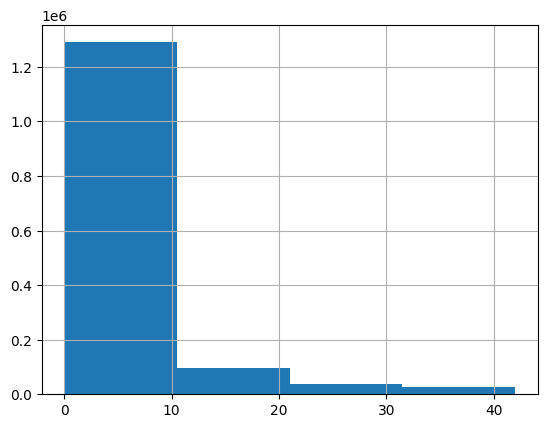

In [32]:
merge_def["coef_ventas"].hist(bins=4)